In [ ]:
from sklearn.datasets import fetch_lfw_people 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
import numpy as np 
# Download the data, if not already on disk and load it as numpy arrays 
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4) 
# Extract the meaningful parameters of the faces dataset 
# introspect the images arrays to find the shapes (for plotting) 
n_samples, h, w = lfw_people.images.shape 
# for machine learning we use the 2 data directly (as relative pixel # positions info is ignored by this model) 
X = lfw_people.data 
n_features = X.shape[1] 
# the label to predict is the id of the person 
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 
print("Total dataset size:") 
print("n_samples: %d" % n_samples) 
print("n_features: %d" % n_features) 
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [5]:
# Center data
mean = np. mean (X_train, axis=0)
X_train -= mean 
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))
#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


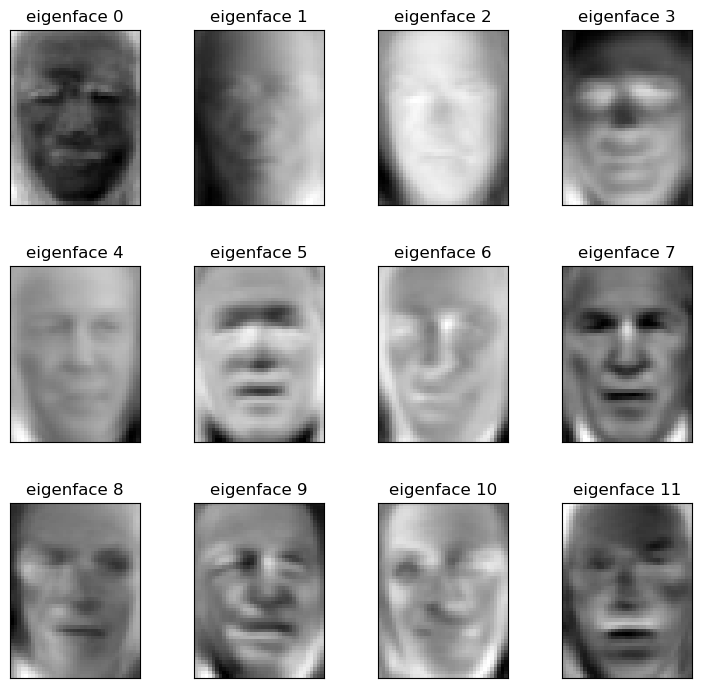

In [6]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery (images, titles, h, w, n_row=3, n_col=4):
    "Helper function to plot a gallery of portraits"
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust (bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range (eigenfaces.shape[0])]
plot_gallery (eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


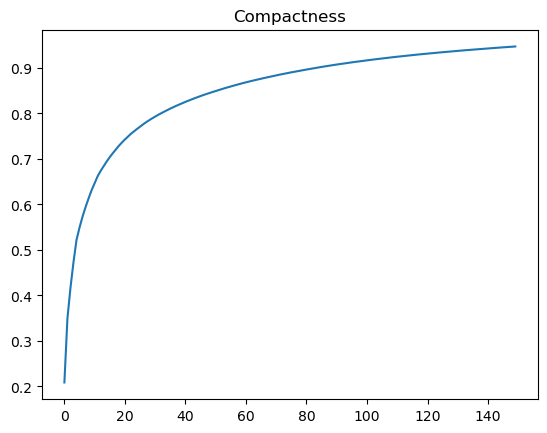

In [7]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score 
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train)
#expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 3 3 3 3 3 4 3 3 4 1 3 3 3 1 1 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 6 3 6 1 3 4 3 5 1 4 1 3 6 6 3 3
 3 2 3 1 3 3 6 3 3 3 3 3 3 3 3 1 3 6 3 3 1 1 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 4 3 3 3 3 1 3 3 3 3
 4 1 1 3 3 3 3 3 6 1 3 3 6 5 5 1 3 3 5 1 3 3 1 3 3 1 5 3 3 3 3 6 3 3 3 1 2
 3 3 3 3 2 4 3 2 3 4 3 3 3 3 6 3 3 3 3 5 1 4 2 4 3 1 5 3 3 4 3 3 1 3 3 3 6
 3 1 1 3 3 3 1 3 3 3 3 0 3 1 3 6 3 3 3 4 2 3 3 3 3 3 3 6 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 6 6 1 3 3 6 3 3 3 3 3 1 1 3 3 3 3 3 3 3 4 3 3 5 3 3 3
 3 5 3 3 3 6 6 3 1 3 1 3 1 3 3 3 1 3 1 3 3 1 3 3 5 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

In [9]:
import torch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
# Center data
mean_torch = torch.mean(X_train_torch, dim=0)
X_train_torch -= mean_torch
X_test_torch -= mean_torch
components_torch = X_train_torch.shape[0]
covariance_matrix = (X_train_torch.T @ X_train_torch) / (n_samples - 1)
#Eigen-decomposition
eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)

sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 'k' eigenvectors (principal components)
top_k_eigenvectors = sorted_eigenvectors[:, :n_components]

# 5. Project the data onto the new 'face space'
# This is your final feature set for the Random Forest
X_train_transformed_torch = X_train_torch @ top_k_eigenvectors
X_test_transformed_torch = X_test_torch @ top_k_eigenvectors


In [10]:
# Convert tensors back to NumPy for scikit-learn
X_train_transformed = X_train_transformed_torch.numpy()
X_test_transformed = X_test_transformed_torch.numpy()

# Build and train the Random Forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_train_transformed, y_train)

# Make predictions and evaluate
predictions = estimator.predict(X_test_transformed)
correct = predictions == y_test
total_test = len(X_test_transformed)

print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:", correct)
print("Total Correct:", np.sum(correct))
print("Accuracy:", np.sum(correct) / total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 4 3 3 3 3 4 3 3 4 1 1 3 3 0 1 4 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 6 1 3 3 3 5 3 4 1 3 6 6 3 3
 3 2 3 1 3 3 6 3 3 3 3 3 3 3 3 3 5 6 3 3 1 3 3 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 4 3 1 3 6 6 6 3 3 4 3 3 4 3 3 3 3 1 3 3 3 3
 3 1 1 3 3 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 3 1 3
 3 3 3 3 2 5 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 3 2 3 5 3 3 4 3 3 1 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 1 6 3 3 3 4 1 3 3 3 3 3 3 5 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 6 3 3 3 6 3 3 3 3 3 1 1 3 3 3 3 3 3 3 4 2 3 5 3 3 3
 3 5 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 5 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
  True  True False  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True  True  True False False  True
 False  T

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# --- Load and Preprocess Data ---

# Load the dataset (min_faces_per_person is a good way to control class count)
# resize=0.4 makes images smaller (50x37) for faster training
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Get image dimensions and number of classes
n_samples, h, w = lfw_people.images.shape
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
num_classes = target_names.shape[0]

print(f"Dataset loaded: {n_samples} samples, {num_classes} classes.")
print(f"Image dimensions: {h}x{w}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Reshape for PyTorch: (n_samples, height, width) -> (n_samples, 1, height, width)
# The '1' represents the single color channel (grayscale)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Datasets and DataLoaders for batching
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Dataset loaded: 1288 samples, 7 classes.
Image dimensions: 50x37


In [12]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super(FaceCNN, self).__init__()
        
        # --- Convolutional Layers ---
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- Dense (Fully Connected) Layers ---
        # Note: The input features for the first dense layer depends on image size.
        # For a 50x37 image, after two 2x2 max pools, the size is 12x9.
        # So, flattened size = 32 filters * 12 * 9 = 3456
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 12 * 9, 512), # Calculated flattened size
            nn.ReLU(),
            nn.Linear(512, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dense_layers(x)
        return x

# Instantiate the model
model = FaceCNN(num_classes=num_classes)
print(model)

FaceCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3456, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=7, bias=True)
  )
)


In [13]:
# --- Hyperparameters ---
learning_rate = 0.001
epochs = 15

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss() # This combines LogSoftmax and NLLLoss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training Loop ---
for epoch in range(epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

Epoch [1/15], Loss: 1.7372
Epoch [2/15], Loss: 1.6774
Epoch [3/15], Loss: 1.5518
Epoch [4/15], Loss: 1.2467
Epoch [5/15], Loss: 0.9683
Epoch [6/15], Loss: 0.6656
Epoch [7/15], Loss: 0.5220
Epoch [8/15], Loss: 0.4140
Epoch [9/15], Loss: 0.3359
Epoch [10/15], Loss: 0.2661
Epoch [11/15], Loss: 0.1831
Epoch [12/15], Loss: 0.1456
Epoch [13/15], Loss: 0.1051
Epoch [14/15], Loss: 0.0840
Epoch [15/15], Loss: 0.0693
Finished Training


In [14]:
# --- Evaluation ---
model.eval() # Set the model to evaluation mode
correct = 0
total = 0

# No need to track gradients for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')

Accuracy of the network on the 322 test images: 85.40 %
